# Wine recommendation project





In [ ]:
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn

import os

import pickle
import regex
import spacy
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, sigmoid_kernel
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


import torchtext
from torchtext.data import get_tokenizer
from torch.nn.utils.rnn import pad_sequence

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import random_split
import torch.nn.functional as F


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sqlalchemy import create_engine

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
wine_dataset = pd.read_csv('/content/drive/MyDrive/CISC684-Intro to ML/Project/winemag-data-130k-v2.csv')

In [ ]:
wine_dataset_relevant = wine_dataset[['title', 'description']]
wine_dataset_relevant.head(10)
wine_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [ ]:
wine_dataset.drop('Unnamed: 0', axis = 1, inplace = True)
wine_dataset.drop('region_2', axis = 1, inplace = True)
wine_dataset.drop('taster_twitter_handle', axis = 1, inplace = True)
wine_dataset.sample(5)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
19581,Austria,One of Bründlmayer's specialities is the lyre ...,Zöbinger Heiligenstein Lyra,94,58.0,Kamptal,NaN,Roger Voss,Bründlmayer 2006 Zöbinger Heiligenstein Lyra R...,Riesling,Bründlmayer
25417,US,The Beckett brothers' 50-50 blend of Tempranil...,El Perfecto,90,35.0,California,Paso Robles,Matt Kettmann,Chronic Cellars 2013 El Perfecto Red (Paso Rob...,Red Blend,Chronic Cellars
116915,Argentina,"Inky at first, this smells leathery, stewy and...",NaN,83,12.0,Mendoza Province,Mendoza,Michael Schachner,Tilia 2013 Malbec-Syrah (Mendoza),Malbec-Syrah,Tilia
27613,US,"Big, ripe, chocolaty wine, with lots of forwar...",Bismark Ranch,88,45.0,California,Sonoma Valley,Paul Gregutt,Hanna 1997 Bismark Ranch Zinfandel (Sonoma Val...,Zinfandel,Hanna
62816,France,"A warm and rich wine, full of ripe black fruit...",NaN,87,NaN,Bordeaux,Cadillac Côtes de Bordeaux,Roger Voss,Château des Mille Anges 2010 Cadillac Côtes d...,Bordeaux-style Red Blend,Château des Mille Anges


In [ ]:
predictors = wine_dataset[['country', 'description', 'designation', 'province', 'region_1', 'variety', 'winery']]
predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   country      129908 non-null  object
 1   description  129971 non-null  object
 2   designation  92506 non-null   object
 3   province     129908 non-null  object
 4   region_1     108724 non-null  object
 5   variety      129970 non-null  object
 6   winery       129971 non-null  object
dtypes: object(7)
memory usage: 6.9+ MB


In [ ]:
predictors.dropna(inplace = True)

<ipython-input-8-60503caa6eda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictors.dropna(inplace = True)


In [ ]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75036 entries, 0 to 129970
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   country      75036 non-null  object
 1   description  75036 non-null  object
 2   designation  75036 non-null  object
 3   province     75036 non-null  object
 4   region_1     75036 non-null  object
 5   variety      75036 non-null  object
 6   winery       75036 non-null  object
dtypes: object(7)
memory usage: 4.6+ MB


In [ ]:
predictors = predictors.reset_index()

In [ ]:
predictors.description.duplicated().value_counts()

False    69317
True      5719
Name: description, dtype: int64

In [ ]:
predictors.duplicated().value_counts()

False    75036
dtype: int64

In [ ]:
predictors[(predictors.description.duplicated() == True)]

,index,country,description,designation,province,region_1,variety,winery
1371,2409,Italy,There's a touch of toasted almond at the start...,Sallier de la Tour,Sicily & Sardinia,Sicilia,Grillo,Tasca d'Almerita
1373,2412,Italy,The Monica grape often shows a rustic or raw q...,Dolia,Sicily & Sardinia,Monica di Sardegna,Monica,Cantine di Dolianova
1374,2413,France,"Fruity and lightly herbaceous, this has fine t...",La Fleur d'Amélie,Bordeaux,Bordeaux Blanc,Bordeaux-style White Blend,Château de Sours
1375,2414,Italy,"A blend of Nero d'Avola and Nerello Mascalese,...",Rosso,Sicily & Sardinia,Sicilia,Red Blend,Corvo
1973,3431,France,The wine is still young with its crisp red fru...,Les Michelons,Beaujolais,Moulin-à-Vent,Gamay,Yohan Lardy
...,...,...,...,...,...,...,...,...
74988,129877,France,An open and inviting scent of ripe pear is fre...,Cuvée Engel,Alsace,Alsace,Pinot Gris,Domaine Fernand Engel
74989,129878,US,"Light in color and nuanced in oak, this full-b...",Dutton Ranch,California,Russian River Valley,Chardonnay,MacRostie
74990,129879,US,"This wine is a blend of 45% Grenache, 37% Syra...",Metis,Washington,Columbia Valley (WA),Red Blend,Maison Bleue
74991,129882,US,"This wine is mostly Cabernet Sauvignon (78%), ...",Reserve,Washington,Columbia Valley (WA),Bordeaux-style Red Blend,Matthews


In [ ]:
predictors['name'] = predictors['winery'] + ', ' + predictors['designation']
predictors.drop('index', axis=1, inplace=True)

In [ ]:
predictors.sample(10)

,country,description,designation,province,region_1,variety,winery,name
36432,France,"Still young, this wine promises great potentia...",Vieilles Vignes Sur Lie,Loire Valley,Muscadet Sèvre et Maine,Melon,Gadais Père et Fils,"Gadais Père et Fils, Vieilles Vignes Sur Lie"
28536,US,"The aromas of black fruit, vanilla and high-to...",Exordium Weinbau Vineyard,Washington,Wahluke Slope,Cabernet Sauvignon,Script,"Script, Exordium Weinbau Vineyard"
64863,Australia,"On the quiet side for a Grenache, with reticen...",The Custodian,South Australia,McLaren Vale,Grenache,D'Arenberg,"D'Arenberg, The Custodian"
14091,Italy,White flower and orchard fruit aromas come tog...,Fontègo,Veneto,Soave,White Blend,La Cappuccina,"La Cappuccina, Fontègo"
33635,US,"Leveled by 4% Grenache, this Syrah, which is m...",Buxom,California,Paso Robles,Syrah,Nicora,"Nicora, Buxom"
64470,US,This wine is a blend of 60% Syrah from Funk Es...,Hunt & Gather,Washington,Walla Walla Valley (WA),Red Blend,Saviah,"Saviah, Hunt & Gather"
9694,France,"Lush, ripe and a touch heady, this is a rich s...",Resplandy,Languedoc-Roussillon,Muscat de Saint-Jean de Minervois,Muscat Blanc à Petits Grains,Les Vignerons de la Méditerranée,"Les Vignerons de la Méditerranée, Resplandy"
46531,Argentina,"Consistent with prior vintages, this Malbec is...",Las Divas Vineyard Gran,Mendoza Province,Tupungato,Malbec,Riglos,"Riglos, Las Divas Vineyard Gran"
13133,Italy,There's a lot of excitement surrounding the li...,Castelline,Northeastern Italy,Garda Classico,Groppello,Costaripa,"Costaripa, Castelline"
45218,Argentina,Generally this is a nice South American Chardo...,Saurus Patagonia,Other,Neuquén,Chardonnay,Familia Schroeder,"Familia Schroeder, Saurus Patagonia"


In [ ]:
predictors.drop_duplicates(inplace=True)
#predictors.reset_index(inplace=True)
#predictors.drop('index', axis=1, inplace=True)

In [ ]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69330 entries, 0 to 75035
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   country      69330 non-null  object
 1   description  69330 non-null  object
 2   designation  69330 non-null  object
 3   province     69330 non-null  object
 4   region_1     69330 non-null  object
 5   variety      69330 non-null  object
 6   winery       69330 non-null  object
 7   name         69330 non-null  object
dtypes: object(8)
memory usage: 4.8+ MB


In [ ]:
predictors.country.value_counts()

US           33989
France       13326
Italy        12781
Spain         4884
Argentina     2654
Australia     1538
Canada         158
Name: country, dtype: int64

In [ ]:
predictors.name.duplicated().value_counts()

False    41590
True     27740
Name: name, dtype: int64

In [ ]:
predictors.drop_duplicates(subset='name', keep='last', inplace=True)

In [ ]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41590 entries, 0 to 75035
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   country      41590 non-null  object
 1   description  41590 non-null  object
 2   designation  41590 non-null  object
 3   province     41590 non-null  object
 4   region_1     41590 non-null  object
 5   variety      41590 non-null  object
 6   winery       41590 non-null  object
 7   name         41590 non-null  object
dtypes: object(8)
memory usage: 2.9+ MB


In [ ]:
predictors.reset_index(inplace=True)

In [ ]:
predictors.drop('index', axis=1, inplace=True)

In [ ]:
predictors = predictors[['description', 'variety']]
predictors.head()

,description,variety
0,"Aromas include tropical fruit, broom, brimston...",White Blend
1,"Pineapple rind, lemon pith and orange blossom ...",Riesling
2,"Much like the regular bottling from 2012, this...",Pinot Noir
3,Blackberry and raspberry aromas show a typical...,Tempranillo-Merlot
4,This is dominated by oak and oak-driven aromas...,Nerello Mascalese


In [ ]:
predictors.variety.value_counts().head(10)

Pinot Noir                  4729
Red Blend                   4099
Chardonnay                  3624
Cabernet Sauvignon          2390
Bordeaux-style Red Blend    2132
Syrah                       1355
Rosé                        1288
Sparkling Blend             1231
Zinfandel                   1205
White Blend                 1142
Name: variety, dtype: int64

In [ ]:
varieties = predictors['variety'].isin(['Pinot Noir',
                                   'Red Blend',
                                   'Chardonnay',
                                   'Cabernet Sauvignon',
                                   'Bordeaux-style Red Blend',
                                   'Syrah',
                                   'Rosé',
                                   'Sparkling Blend',
                                   'Zinfandel',
                                   'White Blend'])
predictors = predictors[varieties]
predictors.head()

,description,variety
0,"Aromas include tropical fruit, broom, brimston...",White Blend
2,"Much like the regular bottling from 2012, this...",Pinot Noir
6,Ripe aromas of dark berries mingle with ample ...,Red Blend
8,"Aromas suggest mature berry, scorched earth, a...",Red Blend
9,Merlot and Nero d'Avola form the base for this...,Red Blend


In [ ]:
other_variety = ['Nebbiolo',
                 'Riesling',
                 'Champagne Blend',
                 'Sauvignon Blanc',
                 'Malbec',
                 'Sangiovese',
                 'Tempranillo',
                 'Rhône-style Red Blend',
                 'Merlot',
                 'Glera',
                 'Gamay',
                 'Cabernet Franc',
                 'Tempranillo Blend',
                 'Barbera',
                 'Pinot Gris',
                 'Shiraz',
                 'Grenache',
                 'Gewürztraminer',
                 'Bordeaux-style White Blend',
                 'Viognier',
                 'Petite Sirah',
                 'Rhône-style White Blend',
                 'Corvina, Rondinella, Molinara',
                 'Pinot Grigio',
                 'Chenin Blanc',
                 'Melon',
                 'Garnacha',
                 'Aglianico',
                 'Sangiovese Grosso',
                 'Prosecco',
                 'Moscato',
                 "Nero d'Avola",
                 'Albariño',
                 'Garganega',
                 'Montepulciano',
                 'Primitivo',
                 'Pinot Nero',
                 'Vermentino',
                 'Pinot Blanc',
                 'G-S-M']

<ipython-input-28-b3074fa923ca>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize = 5);


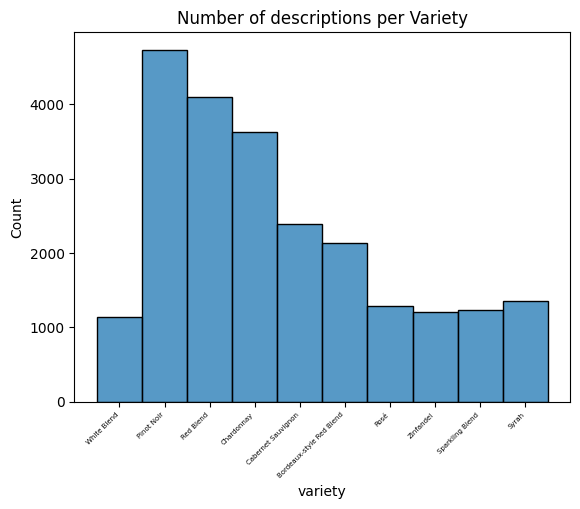

In [ ]:
chart = sns.histplot(predictors.variety)

plt.title("Number of descriptions per Variety")

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize = 5);

In [ ]:
# List of wine varieties
wine_varieties = ['Pinot Noir',
                  'Red Blend',
                  'Chardonnay',
                  'Cabernet Sauvignon',
                  'Bordeaux-style Red Blend',
                  'Syrah','Rosé',
                  'Sparkling Blend',
                  'Zinfandel',
                  'White Blend']

# Initialize an empty list to store dataframes of different varieties
wine_dfs = []

# Loop through each wine variety and select the corresponding dataframe
for variety in wine_varieties:
    wine_df = predictors[predictors['variety'] == variety]
    wine_dfs.append(wine_df)

# Find the variety with the least count
min_count_variety = min(wine_dfs, key = lambda x: len(x))

# Initialize an empty list to store balanced dataframes
balanced_dfs = []

# Loop through each wine dataframe and balance the dataset using the minimum count variety
for wine_df in wine_dfs:
    balanced_df = wine_df.sample(n=len(min_count_variety), random_state=42)
    balanced_dfs.append(balanced_df)

# Concatenate the balanced dataframes into a single dataframe to create the final balanced training dataset
balanced_train_df = pd.concat(balanced_dfs)

# Shuffle the final balanced training dataset
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42)


<ipython-input-30-003e883f75f2>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize = 5);


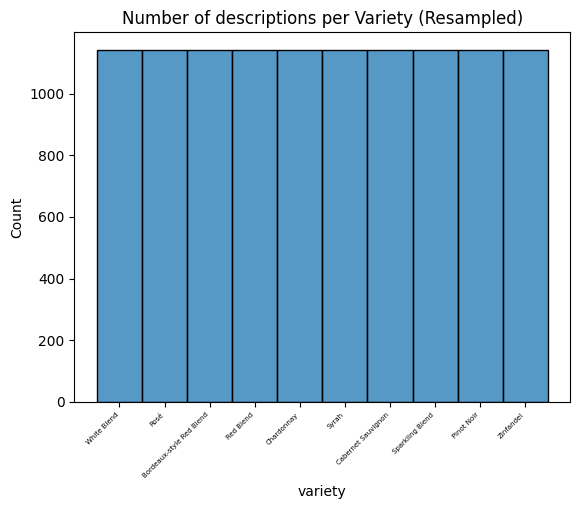

In [ ]:
chart = sns.histplot(balanced_train_df.variety)
plt.title("Number of descriptions per Variety (Resampled)")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize = 5);

In [ ]:
balanced_train_df['description'] = balanced_train_df['description'].str.lower()

In [ ]:
import string
import re

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_punctuation_extra(text):
    text = re.sub('[—-]', ' ', text)
    text = re.sub('[”“]', '', text)
    return text

balanced_train_df['description'] = balanced_train_df['description'].apply(remove_punctuation_extra)
balanced_train_df['description'] = balanced_train_df['description'].apply(remove_punctuation)

In [ ]:
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    removed = [i for i in text.split() if i not in stopwords]
    return removed

balanced_train_df['description'] = balanced_train_df['description'].apply(remove_stopwords)
balanced_train_df['description'] = balanced_train_df['description'].str.join(' ')

In [ ]:
balanced_train_df.head()

,description,variety
22369,swirls glass release whites heady stone fruit ...,White Blend
4602,lightly citrus aromas open wine offers tropica...,Rosé
30604,ripe generous wine solid tannins well red plum...,Bordeaux-style Red Blend
1357,wine blend cabernet sauvignon syrah merlot bur...,Red Blend
35510,rounded ripe fruit dominating new wood influen...,Bordeaux-style Red Blend


In [ ]:
balanced_train_df.to_csv("balanced_train_data.csv", index=False)

In [ ]:
from gensim.models import Word2Vec

desc_tokenized = balanced_train_df.apply(lambda row: nltk.word_tokenize(row['description']), axis=1)
desc_tokenized

22369    [swirls, glass, release, whites, heady, stone,...
4602     [lightly, citrus, aromas, open, wine, offers, ...
30604    [ripe, generous, wine, solid, tannins, well, r...
1357     [wine, blend, cabernet, sauvignon, syrah, merl...
35510    [rounded, ripe, fruit, dominating, new, wood, ...
                               ...                        
21153    [crystalline, galician, blend, composed, 95, g...
17181    [91, 93, barrel, sample, delicious, wine, ripe...
36354    [elegant, aromas, suggest, tar, prune, cherry,...
4283     [bit, light, body, rich, raspberries, cherries...
37443    [winery, makes, one, better, consistent, white...
Length: 11420, dtype: object

In [ ]:
desc_tokenized.to_csv("tokenize_desc.csv", index = False)

In [ ]:
model = Word2Vec(desc_tokenized, vector_size=100, window=20)


print(model)
print(list(model.wv.key_to_index)[:10])
print(model.wv.get_vector('wine'))

Word2Vec<vocab=4149, vector_size=100, alpha=0.025>
['wine', 'flavors', 'fruit', 'aromas', 'palate', 'acidity', 'finish', 'black', 'tannins', 'cherry']
[ 1.5438195e-01  2.6639178e-01  2.2457230e-01 -1.1755683e-01
 -2.3610616e-01 -6.1001456e-01  5.3954768e-01  7.1823877e-01
 -4.1442126e-01 -6.3220191e-01  3.9031461e-01 -4.4650704e-01
 -2.2247241e-01  1.2742916e-01  4.3762332e-01 -5.9506094e-01
 -6.3991404e-01  4.3437713e-01 -1.9365471e-02 -6.1109006e-01
  2.6200015e-02  1.1480804e-01  8.8554460e-01  1.7538844e-02
 -4.6627039e-01 -2.2068258e-01 -1.9991006e-01 -5.5664644e-02
  9.1028638e-02 -1.5930326e-01  6.6146362e-01  1.3460479e-02
  1.3583171e+00 -1.2188773e+00 -1.1725525e-01 -2.5625452e-01
  2.5218645e-01  5.2893752e-01 -1.5691468e-01 -1.1130122e-01
  3.3279896e-01  2.1414366e-02  2.5263235e-01  5.4902279e-01
 -1.9307792e-01 -4.3124847e-02  2.2813587e-02  6.8405837e-02
  6.5445429e-01  1.3713877e-03 -4.5445108e-01 -4.6368507e-01
  1.9549091e-01  6.6257149e-01 -1.4840972e-01 -3.5341507

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !apt install unzip
# !unzip "glove.6B.zip"

In [ ]:
import os
os.listdir()

['.config',
 'glove.6B.300d.txt',
 'glove.6B.zip.1',
 'tokenize_desc.csv',
 'glove.6B.200d.txt',
 'glove.6B.zip',
 'checkpoint',
 'glove.6B.100d.txt',
 'gensim_glove_vectors.txt',
 'glove.6B.50d.txt',
 'drive',
 'balanced_train_data.csv',
 'sample_data']

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="glove.6B.300d.txt", word2vec_output_file="gensim_glove_vectors.txt")

<ipython-input-44-0ef8d1b39741>:2: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file="glove.6B.300d.txt", word2vec_output_file="gensim_glove_vectors.txt")


(400000, 300)

In [ ]:
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_train_df['description'])
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
list(tokenizer.word_index)[:15]

['wine',
 'flavors',
 'fruit',
 'aromas',
 'palate',
 'acidity',
 'finish',
 'black',
 'tannins',
 'cherry',
 'ripe',
 'drink',
 'blend',
 'red',
 'dry']

In [ ]:
# integer encode the documents
encoded_docs = tokenizer.texts_to_sequences(balanced_train_df['description'])

# pad documents
MAX_LENGTH=balanced_train_df['description'].str.split().str.len().max()
padded_docs = pad_sequences(encoded_docs, maxlen = MAX_LENGTH, padding='post')
padded_docs

array([[2594,  227,  742, ...,    0,    0,    0],
       [ 193,   42,    4, ...,    0,    0,    0],
       [  11,  185,    1, ...,    0,    0,    0],
       ...,
       [ 109,    4,  521, ...,    0,    0,    0],
       [  82,   33,  228, ...,    0,    0,    0],
       [ 401,  257,   77, ...,    0,    0,    0]], dtype=int32)

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Convert GloVe format to Word2Vec format
glove_file_path = '/content/glove.6B.300d.txt'
word2vec_file_path = '/content/gensim_glove_vectors.txt'
glove2word2vec(glove_input_file = glove_file_path, word2vec_output_file = word2vec_file_path)

# Load pre-trained GloVe embeddings as Word2Vec format
word2vec_embeddings = KeyedVectors.load_word2vec_format(word2vec_file_path)

# Load pre-trained GloVe embeddings
#glove_file_path = '/content/glove.6B.300d.txt'
#word2vec_embeddings = KeyedVectors.load_word2vec_format(glove_file_path)

embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_embeddings:
        embedding_matrix[i] = word2vec_embeddings[word]

<ipython-input-48-cfbba05e5b7e>:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file = glove_file_path, word2vec_output_file = word2vec_file_path)


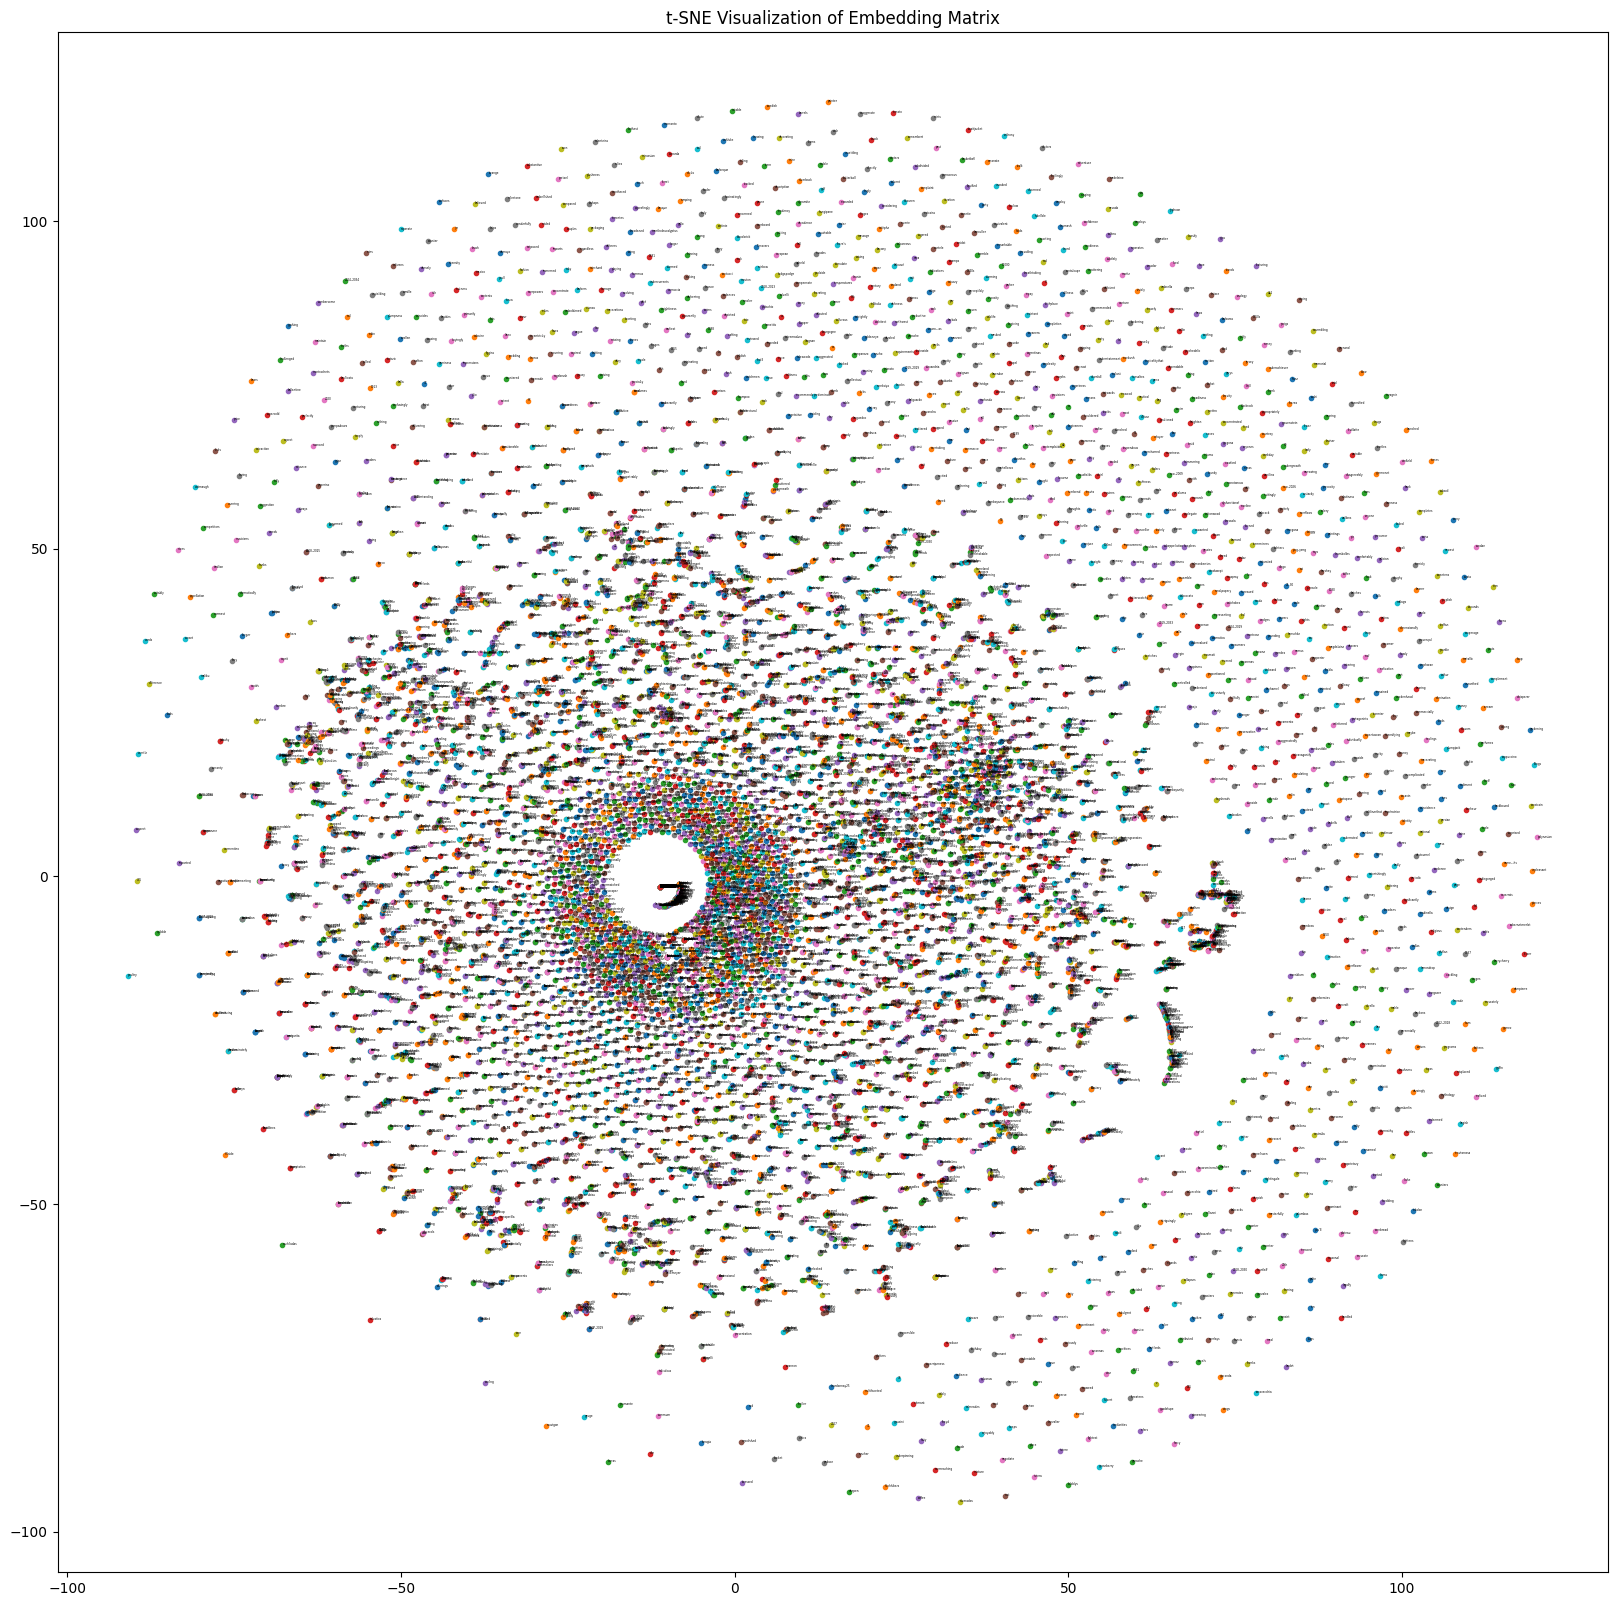

In [ ]:
from sklearn.manifold import TSNE
# List of words corresponding to the embedding_matrix
words = list(tokenizer.word_index.keys())

# Create a t-SNE model
tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=1000, random_state=23)

#TSNE(n_components=2, perplexity=30, n_iter=300)


# Fit the model to the embedding matrix
embedded_matrix_tsne = tsne.fit_transform(embedding_matrix)

# Plot the t-SNE visualization
plt.figure(figsize=(20, 20))
for i, word in enumerate(words):
    plt.scatter(embedded_matrix_tsne[i, 0], embedded_matrix_tsne[i, 1], marker='.')
    plt.text(embedded_matrix_tsne[i, 0], embedded_matrix_tsne[i, 1], word, fontsize = 2)

plt.title('t-SNE Visualization of Embedding Matrix')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Convert to PyTorch tensors
padded_sequences = torch.tensor(padded_docs, dtype=torch.long).to(device)

# Use LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(balanced_train_df['variety'])

# # Convert the numerical labels to PyTorch tensor
labels = torch.tensor(labels, dtype=torch.long).to(device)

In [ ]:
X = padded_sequences
y = labels
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state =42)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 10
# Create DataLoader for training
train_dataset = TensorDataset(train_data, train_labels)

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)

# Create DataLoader for testing
test_dataset = TensorDataset(test_data, test_labels)

test_loader = DataLoader(test_dataset, batch_size =  batch_size, shuffle=False)

In [ ]:
num_classes = 10
best_acc = 0

In [ ]:
# class LSTMModel(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, embedding_weights, max_length, hidden_size, num_classes):
#         super(LSTMModel, self).__init__()

#         self.embedding = nn.Embedding(vocab_size, embedding_dim)

#         self.embedding.weight = nn.Parameter(torch.tensor(embedding_weights, dtype=torch.float32))

#         self.embedding.weight.requires_grad = False  # To make the embedding non-trainable

#         self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, dropout=0.2)

#         self.global_max_pool = nn.AdaptiveMaxPool1d(1)

#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         embedded = self.embedding(x)
#         lstm_output, _ = self.lstm(embedded)
#         lstm_output = lstm_output.permute(0, 2, 1)
#         global_max_pool_output = self.global_max_pool(lstm_output)
#         global_max_pool_output = global_max_pool_output.squeeze(2)
#         output = self.fc(global_max_pool_output)
#         return output

# # vocab_size - the size of the vocabulary
# # embedding_dim - the dimension of word embeddings
# # embedding_matrix - the pre-trained embedding matrix (numpy array)
# # MAX_LENGTH - the maximum length of input sequences
# # hidden_size - the number of hidden units in the LSTM layer
# # num_classes - the number of classes in your classification task

# hidden_size = 20

# # Instantiate the model
# model = LSTMModel(vocab_size, embedding_dim, embedding_matrix, MAX_LENGTH, hidden_size, num_classes)

# # Print the model summary
# print(model)


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_weights, num_classes):
        super(CNNModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_weights, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # To make the embedding non-trainable

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, embedding_dim), stride=(1, 1))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 1), stride=(1, 1))

       # Global max-pooling layer
        self.global_max_pool = nn.AdaptiveMaxPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(128 , 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add a single-channel dimension for the Conv2d layer
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.global_max_pool(x)
        x = x.view(x.size(0), 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNModel(vocab_size, embedding_dim, embedding_matrix, num_classes)

# Print the model summary
print(model)


CNNModel(
  (embedding): Embedding(12739, 300)
  (conv1): Conv2d(1, 64, kernel_size=(3, 300), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 1), stride=(1, 1))
  (global_max_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
# class FFNNModel(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, embedding_weights, num_classes, hidden_size=252):
#         super(FFNNModel, self).__init__()

#         # Embedding layer
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.embedding.weight = nn.Parameter(torch.tensor(embedding_weights, dtype=torch.float32))
#         self.embedding.weight.requires_grad = False  # To make the embedding non-trainable

#         # Fully connected layers
#         self.fc1 = nn.Linear(embedding_dim, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.fc4 = nn.Linear(hidden_size, hidden_size)
#         self.fc5 = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         x = self.embedding(x)
#         x = torch.mean(x, dim=1)  # Average pooling over the sequence length
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.relu(self.fc4(x))
#         x = self.fc5(x)
#         return x

# # Instantiate the model
# model = FFNNModel(vocab_size, embedding_dim, embedding_matrix, num_classes)

# # Print the model summary
# print(model)


In [ ]:
# class GRUModel(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, embedding_weights, num_classes, hidden_size):
#         super(GRUModel, self).__init__()

#         # Embedding layer
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.embedding.weight = nn.Parameter(torch.tensor(embedding_weights, dtype=torch.float32))
#         self.embedding.weight.requires_grad = False  # To make the embedding non-trainable

#         # GRU layer
#         self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)

#         # Fully connected layer
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         x = self.embedding(x)
#         gru_output, _ = self.gru(x)
#         gru_output = gru_output[:, -1, :]  # Take the last output of the GRU sequence
#         x = self.fc(gru_output)
#         return x

# #hidden size
# hidden_size = 252

# # Instantiate the model
# model = GRUModel(vocab_size, embedding_dim, embedding_matrix, num_classes, hidden_size)

# # Print the model summary
# print(model)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# For CNN, epochs = 15, lr = 0.0001, batch_size = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

#Used for LSTM, epochs = 30, lr = 0.0001, batch_size = 10
#Used for FFNN, epochs = 15, lr = 0.0001, batch_size = 10
#Used for GRU, epochs = 15, lr  = 0.0001, batch_size = 10
#optimizer = torch.optim.RMSprop(model.parameters(), lr= 0.0001, alpha = 0.99, momentum = 0.5, eps = 1e-08)

# Train the NN
start_epoch = 0

# Set the number of training epochs

#num_epochs = 15

#For CNN
num_epochs = 10

# Send the model to device
model.to(device)

CNNModel(
  (embedding): Embedding(12739, 300)
  (conv1): Conv2d(1, 64, kernel_size=(3, 300), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 1), stride=(1, 1))
  (global_max_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# Train the model
def train(epoch):
    print('\nEpoch: %d' % epoch)
    train_losses = [] # needed for visualize the traning loss
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    batch_idx =0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)# get a batch

        # Clear gradient
        optimizer.zero_grad()

        # Forward pass batch through model
        outputs = model(inputs)

        # Calculate loss on batch
        loss = criterion(outputs, targets)

        # Calculate gradients for backward pass
        loss.backward()

        # Update model
        optimizer.step()

        train_loss += loss.item()
        train_losses.append(loss.item())
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 0: # print every 100 iterations
            print(batch_idx, len(train_loader), 'Train Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_losses


In [ ]:
def test(epoch):
    global best_acc
    test_losses = []
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    batch_idx = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass batch through model
            outputs = model(inputs)

            # Calculate loss on batch
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            test_losses.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx % 100 == 0:
                print(batch_idx, len(test_loader), 'Testing Loss: %.3f | Acc: %.3f%% (%d/%d)'
                            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save best model.
    acc = 100.*correct/total
    print('Test Accuracy of the model: {} %'.format(acc))
    if acc > best_acc:
        print('Start Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
        print('Done Saving!')
    return test_losses


In [ ]:
train_losses_over_epochs = []
test_losses_over_epochs = []

for epoch in range(start_epoch, start_epoch + num_epochs):
    l_tr = train(epoch)
    l_te = test(epoch)

    train_losses_over_epochs.append(sum(l_tr)/len(l_tr))
    test_losses_over_epochs.append(sum(l_te) / len(l_te))

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(start_epoch, start_epoch + num_epochs), train_losses_over_epochs, label='Train Loss', color='blue')
plt.plot(range(start_epoch, start_epoch + num_epochs), test_losses_over_epochs, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs Epoch')
plt.legend()
plt.grid()
plt.show()

In [ ]:
checkpoint = torch.load('./checkpoint/ckpt.pth') # load checkpoint
model.load_state_dict(checkpoint['net']) # load model parameter

model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass real batch through model
        outputs = model(inputs)

        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
acc = 100.*correct/total
print('Test Accuracy of the model: {:.3f} %'.format(acc))


# Convert lists to PyTorch tensors
predicted_labels = predicted.clone().detach().cpu()
true_labels = targets.clone().detach().cpu()

# Calculate F1 score
from sklearn.metrics import f1_score

f1 = f1_score(true_labels, predicted_labels, average='macro')*100
print('F1 Score on the testing set: {:.3f} %'.format(f1))

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.title("Training loss", fontsize=15)
plt.plot(l_tr, label= "Training Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
ax.text(0.2, 0.8,'Test Accuracy of the model: {:.3f} %'.format(acc),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
     fontsize=10, color='red')

ax.text(0.2, 0.7,'F1 Score on the testing set: {:.3f} %'.format(f1),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
     fontsize=10, color='red')
plt.legend()
plt.show()

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra punctuation
    text = re.sub('[—-]', ' ', text)
    text = re.sub('[”“]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the tokens back to a string
    processed_text = ' '.join(tokens)

    return processed_text

In [ ]:
def recommend_wine(model, tokenizer, label_encoder, description):
  # Preprocess the description
  preprocessed_description = preprocess_text(description)

  # Tokenize the preprocessed description
  encoded_description = tokenizer.texts_to_sequences([preprocessed_description])


  # Pad the encoded sequence
  padded_sequence = pad_sequences(encoded_description, maxlen=MAX_LENGTH, padding='post')

  # Convert the padded sequence to a PyTorch tensor and move it to the appropriate device
  input_tensor = torch.tensor(padded_sequence, dtype=torch.long).to(device)

  # Ensure the model is in evaluation mode
  model.eval()

  # Pass the tensor through the model
  with torch.no_grad():
      output = model(input_tensor)

  # Get the predicted class probabilities
  probabilities = F.softmax(output, dim=1)

  # Get the predicted class index
  _, predicted_class_idx = torch.max(probabilities, dim=1)

  # Convert the predicted class index to the predicted wine variety
  predicted_wine_variety = label_encoder.inverse_transform(predicted_class_idx.cpu().numpy())[0]

  return predicted_wine_variety

In [ ]:
description = "fun wine for post exam celebration."
recommended_wine = recommend_wine(model, tokenizer, label_encoder, description)
print("Recommended Wine Variety:", recommended_wine)